Склонность клиентов к продуктам

In [ ]:
!pip install catboost
!pip install category_encoders

In [ ]:
import numpy as np
import pandas as pd
import catboost as cb
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, balanced_accuracy_score, roc_auc_score,
                             roc_curve, auc, log_loss)

import matplotlib.pyplot as plt

Функция обучения модели:

In [ ]:
def train_catboost_model(X_train, y_train, X_test, y_test, cat_features=None,
                         iterations=1000, depth=9, learning_rate=0.035,
                         task_type="GPU", verbose=500):
    """
    Обучает модель CatBoost для данного таргета и возвращает её.

    Параметры:
      X_train: DataFrame или array-like, обучающие признаки.
      y_train: Series или array-like, целевая переменная.
      cat_features: список названий категориальных признаков.
      iterations, depth, learning_rate, task_type, verbose: параметры CatBoost.

    Возвращает:
      Обученную модель CatBoostClassifier.
    """
    if cat_features:
      model = cb.CatBoostClassifier(
          iterations=iterations,
          depth=depth,
          learning_rate=learning_rate,
          loss_function='Logloss',
          cat_features=cat_features,
          task_type=task_type,
          verbose=verbose
      )
    else:
       model = cb.CatBoostClassifier(
          iterations=iterations,
          depth=depth,
          learning_rate=learning_rate,
          loss_function='Logloss',
          task_type=task_type,
          verbose=verbose
      )
    model.fit(X_train, y_train, eval_set=(X_test, y_test))
    return model

Функция для оценки качества модели

In [ ]:
def evaluate_catboost_model(model, X_test, y_test, feature_names=None):
    """
    Вычисляет метрики классификации по модели CatBoost, строит ROC-кривую и график важности признаков.

    Параметры:
      model: обученная модель CatBoost.
      X_test: тестовые признаки (DataFrame или array-like).
      y_test: истинные метки тестовой выборки.
      feature_names: (опционально) список названий признаков.

    Возвращает:
      metrics: словарь с метриками (accuracy, precision, recall, f1, balanced_accuracy, auc, logloss).
      fi_df: DataFrame с важностью признаков.
    """
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
        "auc": roc_auc_score(y_test, y_pred_proba),
        "logloss": log_loss(y_test, y_pred_proba)
    }

    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-score: {metrics['f1']:.4f}")
    print(f"Balanced Accuracy: {metrics['balanced_accuracy']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")
    print(f"LogLoss: {metrics['logloss']:.4f}")

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc_val = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc_val:.4f})")
    plt.plot([0,1], [0,1], color="grey", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    importances = model.get_feature_importance()
    if feature_names is None:
        try:
            feature_names = X_test.columns
        except AttributeError:
            feature_names = [f"feature_{i}" for i in range(X_test.shape[1])]
    fi_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    fi_df = fi_df.sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10,6))
    plt.barh(fi_df["Feature"], fi_df["Importance"], color="skyblue")
    plt.gca().invert_yaxis()
    plt.xlabel("Importance")
    plt.title("Feature Importance")
    plt.show()

    return metrics, fi_df

In [ ]:
data = pd.read_csv("known_behaviors2.csv")

target_cols = ["Mortgage", "Pension", "Savings"]

customer_ids = data["customer_id"]

def prepare_data_for_target(df, target, cat_features, id_col="customer_id", encoding_type=None):
    feature_cols = [col for col in df.columns if col not in [id_col] + target_cols]
    X = df[feature_cols]
    y = df[target]
    if not encoding_type:
        return X, y
    if encoding_type == 'onehot':
        X = pd.get_dummies(X, columns=cat_features)
    elif encoding_type == 'target':
        encoder = ce.TargetEncoder(cols=cat_features)
        X = encoder.fit_transform(X, y)
    elif encoding_type == 'ordinal':
        encoder = OrdinalEncoder()
        X = X.copy()
        X[cat_features] = encoder.fit_transform(X[cat_features])
    else:
        raise ValueError("Unknown encoding type")
    return X, y

cat_features = ["gender", "bad_payment", "gold_card", "pension_plan"]

models = {}
metrics_dict = {}
fi_dict = {}


===== Обучение модели для таргета: Mortgage ======
0:	learn: 0.6115666	test: 0.6102064	best: 0.6102064 (0)	total: 169ms	remaining: 2m 48s
500:	learn: 0.1503053	test: 0.1995422	best: 0.1961020 (120)	total: 56.3s	remaining: 56.1s
999:	learn: 0.1268795	test: 0.2046871	best: 0.1961020 (120)	total: 2m 2s	remaining: 0us
bestTest = 0.1961020126
bestIteration = 120
Shrink model to first 121 iterations.

Метрики для модели Mortgage:
Accuracy: 0.8984
Precision: 0.6502
Recall: 0.5955
F1-score: 0.6216
Balanced Accuracy: 0.7716
AUC: 0.9444
LogLoss: 0.1961


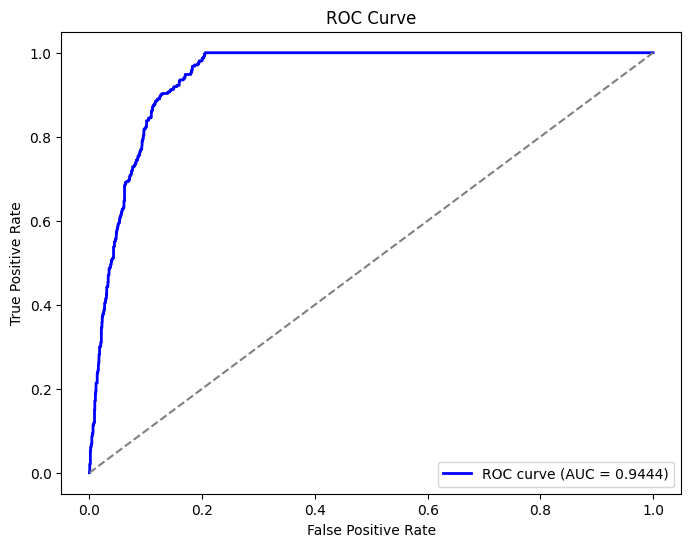

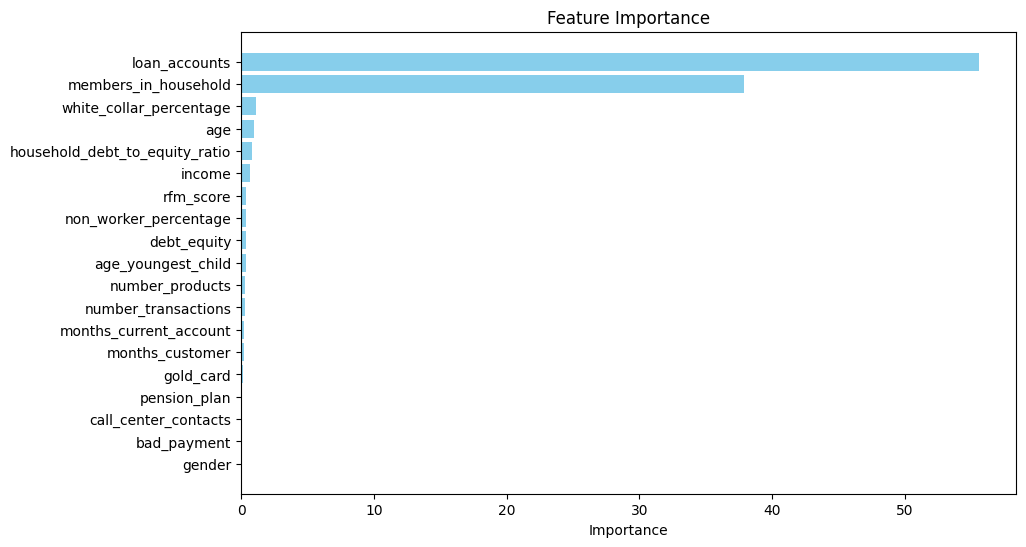


===== Обучение модели для таргета: Pension ======
0:	learn: 0.6602784	test: 0.6610367	best: 0.6610367 (0)	total: 52.8ms	remaining: 52.7s
500:	learn: 0.3594014	test: 0.4473352	best: 0.4381766 (101)	total: 57s	remaining: 56.8s
999:	learn: 0.3246569	test: 0.4604202	best: 0.4381766 (101)	total: 2m 1s	remaining: 0us
bestTest = 0.4381765629
bestIteration = 101
Shrink model to first 102 iterations.

Метрики для модели Pension:
Accuracy: 0.7737
Precision: 0.4800
Recall: 0.0726
F1-score: 0.1261
Balanced Accuracy: 0.5249
AUC: 0.7704
LogLoss: 0.4382


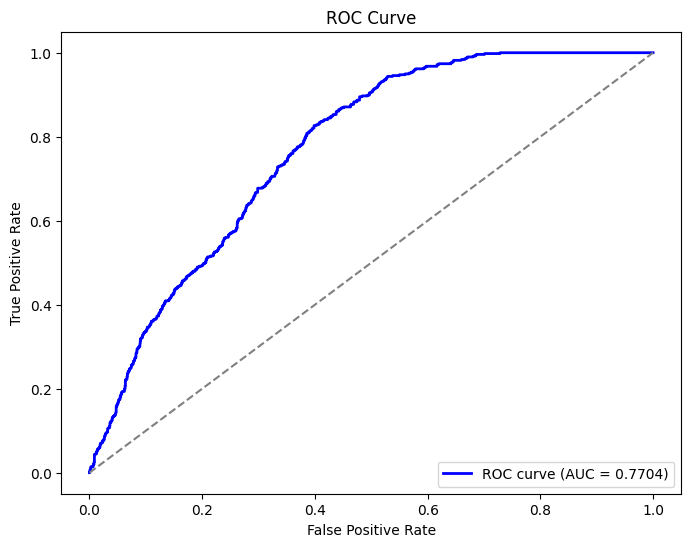

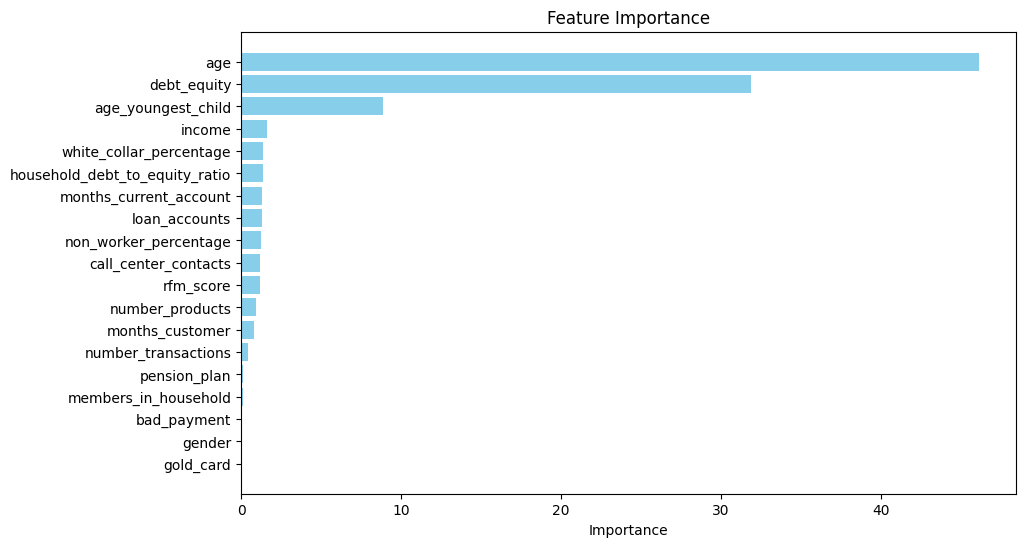


===== Обучение модели для таргета: Savings ======
0:	learn: 0.6860674	test: 0.6859962	best: 0.6859962 (0)	total: 130ms	remaining: 2m 10s
500:	learn: 0.5540013	test: 0.6202550	best: 0.6094468 (62)	total: 55.8s	remaining: 55.5s
999:	learn: 0.5337837	test: 0.6287561	best: 0.6094468 (62)	total: 1m 59s	remaining: 0us
bestTest = 0.6094468028
bestIteration = 62
Shrink model to first 63 iterations.

Метрики для модели Savings:
Accuracy: 0.6281
Precision: 0.5432
Recall: 0.2997
F1-score: 0.3862
Balanced Accuracy: 0.5691
AUC: 0.6810
LogLoss: 0.6094


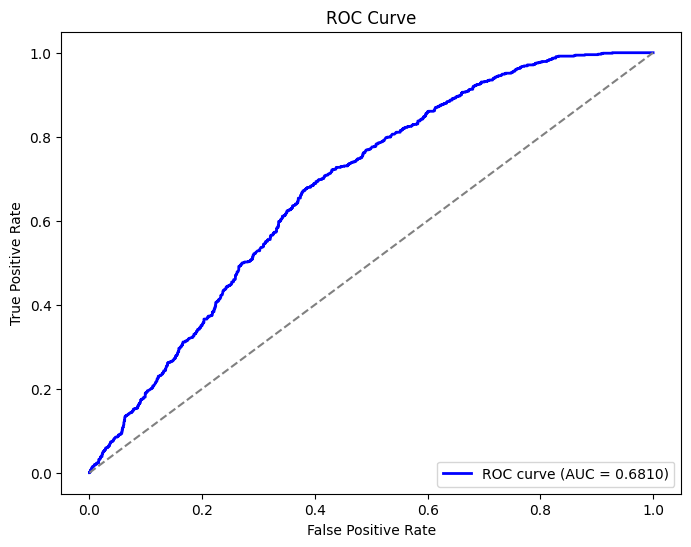

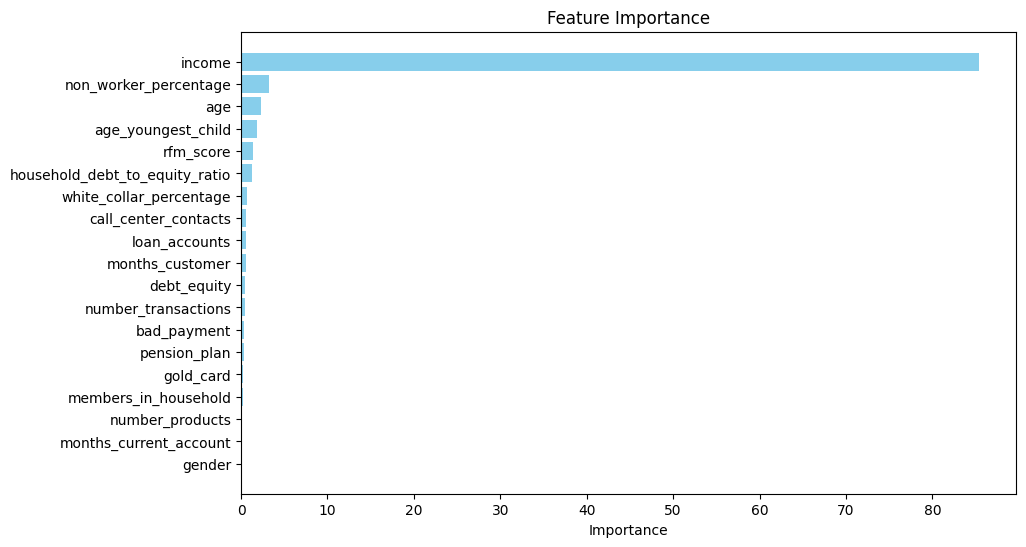

In [ ]:
for target in target_cols:
    print(f"\n===== Обучение модели для таргета: {target} ======")
    X, y = prepare_data_for_target(data, target)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = train_catboost_model(X_train, y_train, X_test, y_test, cat_features)
    models[target] = model

    print(f"\nМетрики для модели {target}:")
    metrics, fi_df = evaluate_catboost_model(model, X_test, y_test, feature_names=X.columns)
    metrics_dict[target] = metrics
    fi_dict[target] = fi_df

In [ ]:
def train_model(data, target_cols, cat_features, encoding_type=None):
    print(f"\n===== Кодировка категориальных признаков: {encoding_type} ======")
    for target in target_cols:
        print(f"\n===== Обучение модели для таргета: {target} ======")
        X, y = prepare_data_for_target(data, target, cat_features, encoding_type=encoding_type)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        if encoding_type:
            model = train_catboost_model(X_train, y_train, X_test, y_test)
        else:
            model = train_catboost_model(X_train, y_train, X_test, y_test, cat_features)
        models[target] = model

        print(f"\nМетрики для модели {target}:")
        metrics, fi_df = evaluate_catboost_model(model, X_test, y_test, feature_names=X.columns)
        metrics_dict[target] = metrics
        fi_dict[target] = fi_df


===== Кодировка категориальных признаков: onehot ======

===== Обучение модели для таргета: Mortgage ======
0:	learn: 0.6369339	test: 0.6366460	best: 0.6366460 (0)	total: 14.7ms	remaining: 14.7s
500:	learn: 0.0835801	test: 0.2165229	best: 0.2023611 (102)	total: 6.66s	remaining: 6.63s
999:	learn: 0.0523731	test: 0.2430368	best: 0.2023611 (102)	total: 14.5s	remaining: 0us

bestTest = 0.2023610987
bestIteration = 102

Shrink model to first 103 iterations.

Метрики для модели Mortgage:
Accuracy: 0.8971
Precision: 0.6395
Recall: 0.6084
F1-score: 0.6235
Balanced Accuracy: 0.7763
AUC: 0.9428
LogLoss: 0.2024


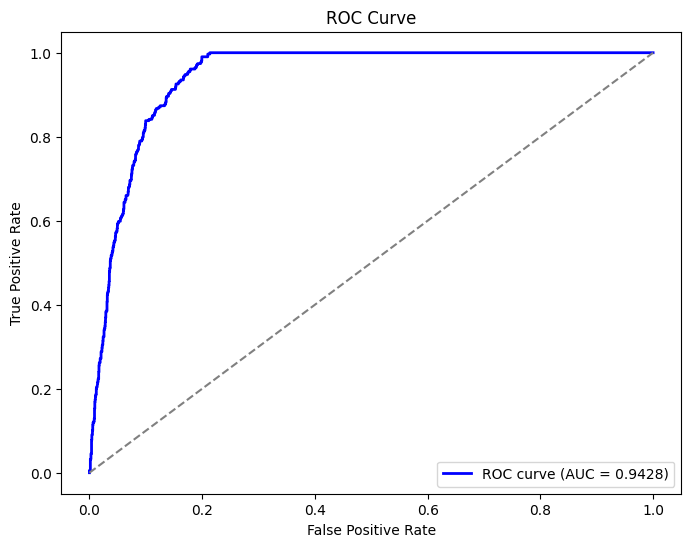

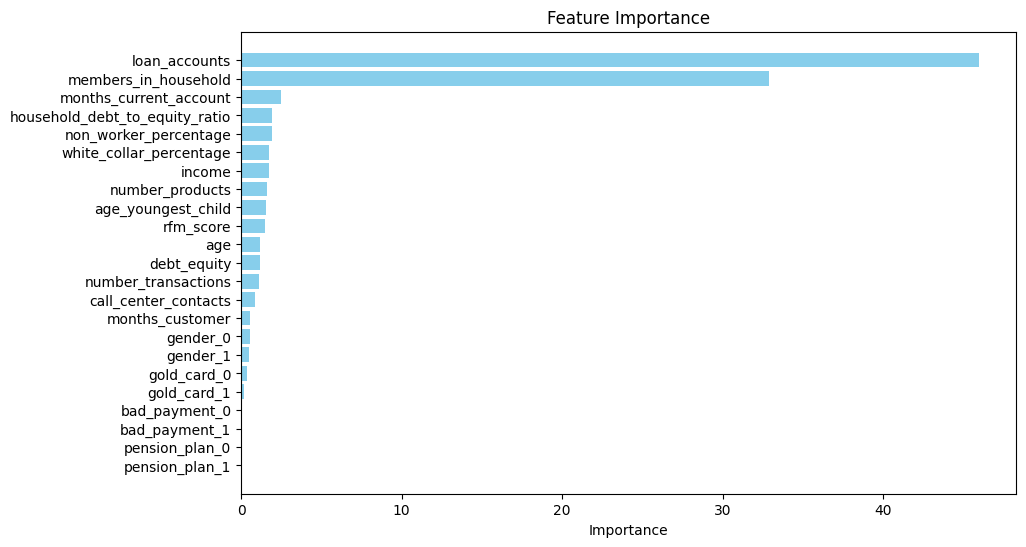


===== Обучение модели для таргета: Pension ======
0:	learn: 0.6677829	test: 0.6682788	best: 0.6682788 (0)	total: 12.6ms	remaining: 12.6s
500:	learn: 0.2421835	test: 0.4646637	best: 0.4395126 (101)	total: 7.7s	remaining: 7.67s
999:	learn: 0.1598075	test: 0.5070264	best: 0.4395126 (101)	total: 14.5s	remaining: 0us

bestTest = 0.4395125974
bestIteration = 101

Shrink model to first 102 iterations.

Метрики для модели Pension:
Accuracy: 0.7737
Precision: 0.4857
Recall: 0.1028
F1-score: 0.1697
Balanced Accuracy: 0.5356
AUC: 0.7686
LogLoss: 0.4395


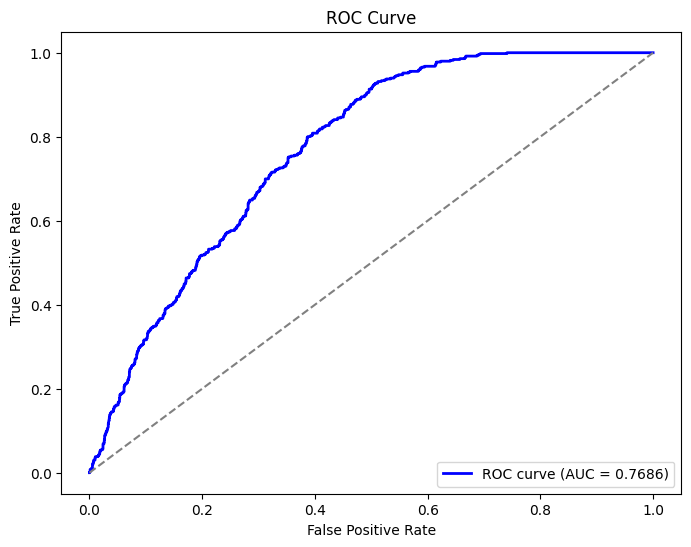

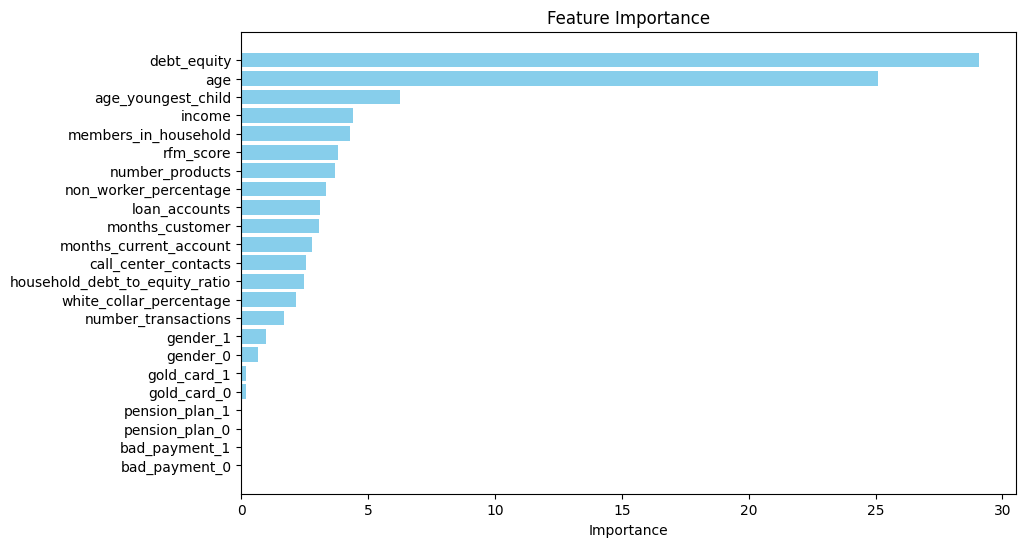


===== Обучение модели для таргета: Savings ======
0:	learn: 0.6856755	test: 0.6861216	best: 0.6861216 (0)	total: 13ms	remaining: 13s
500:	learn: 0.3972115	test: 0.6336003	best: 0.6094317 (102)	total: 8.29s	remaining: 8.26s
999:	learn: 0.2791661	test: 0.6778734	best: 0.6094317 (102)	total: 15s	remaining: 0us

bestTest = 0.6094316593
bestIteration = 102

Shrink model to first 103 iterations.

Метрики для модели Savings:
Accuracy: 0.6195
Precision: 0.5233
Recall: 0.2869
F1-score: 0.3706
Balanced Accuracy: 0.5597
AUC: 0.6776
LogLoss: 0.6094


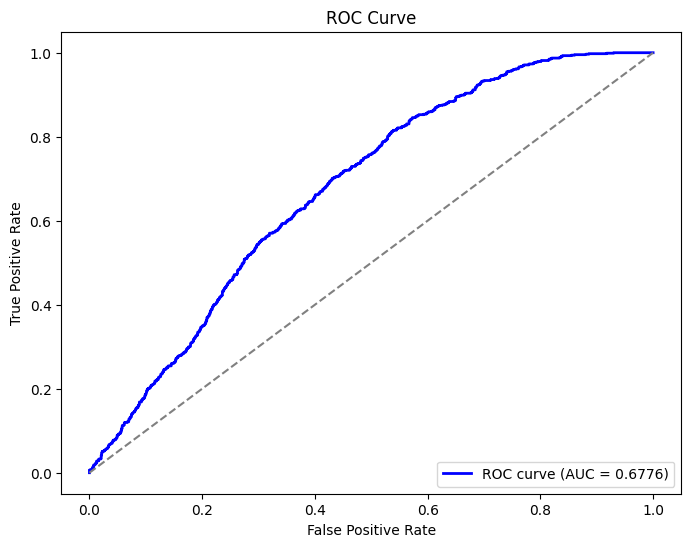

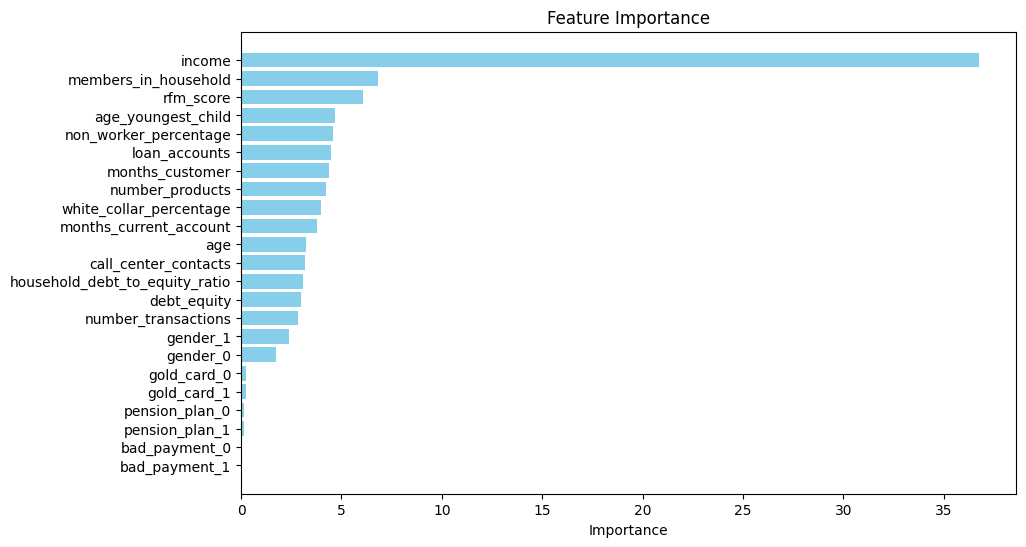


===== Кодировка категориальных признаков: target ======

===== Обучение модели для таргета: Mortgage ======
0:	learn: 0.6390187	test: 0.6390296	best: 0.6390296 (0)	total: 9.6ms	remaining: 9.59s
500:	learn: 0.0840361	test: 0.2148499	best: 0.2011962 (85)	total: 6.18s	remaining: 6.16s
999:	learn: 0.0515156	test: 0.2412839	best: 0.2011962 (85)	total: 11.1s	remaining: 0us

bestTest = 0.2011961518
bestIteration = 85

Shrink model to first 86 iterations.

Метрики для модели Mortgage:
Accuracy: 0.8993
Precision: 0.6516
Recall: 0.6052
F1-score: 0.6275
Balanced Accuracy: 0.7762
AUC: 0.9432
LogLoss: 0.2012


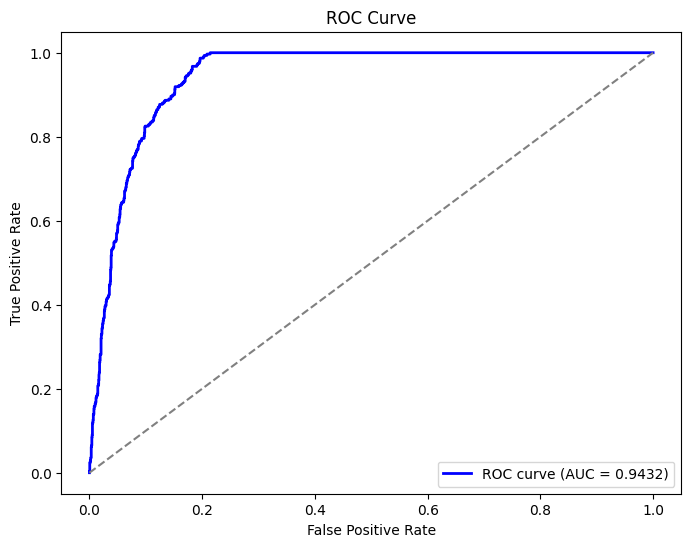

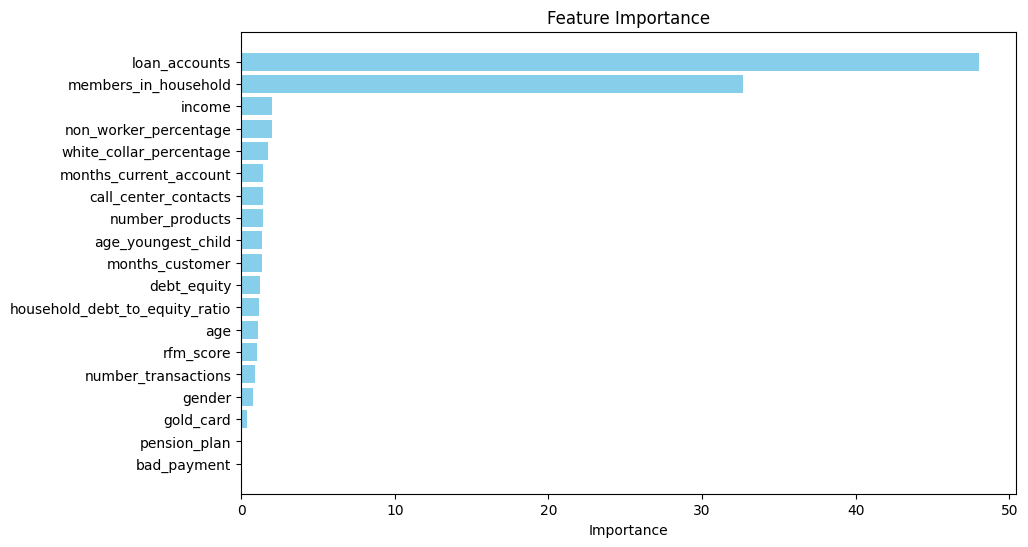


===== Обучение модели для таргета: Pension ======
0:	learn: 0.6706215	test: 0.6713880	best: 0.6713880 (0)	total: 9.39ms	remaining: 9.38s
500:	learn: 0.2463483	test: 0.4629508	best: 0.4406634 (91)	total: 6.71s	remaining: 6.69s
999:	learn: 0.1562687	test: 0.5075153	best: 0.4406634 (91)	total: 11.8s	remaining: 0us

bestTest = 0.4406633784
bestIteration = 91

Shrink model to first 92 iterations.

Метрики для модели Pension:
Accuracy: 0.7741
Precision: 0.4896
Recall: 0.0948
F1-score: 0.1588
Balanced Accuracy: 0.5330
AUC: 0.7661
LogLoss: 0.4407


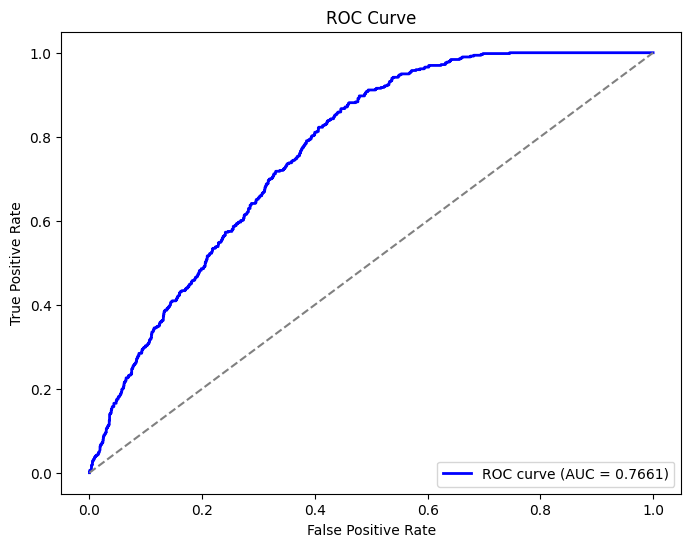

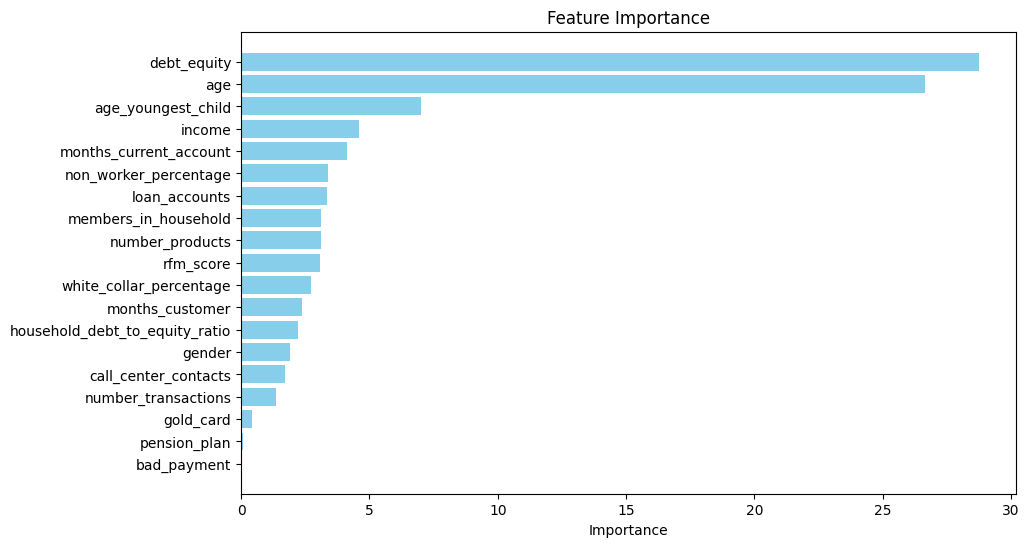


===== Обучение модели для таргета: Savings ======
0:	learn: 0.6858067	test: 0.6864175	best: 0.6864175 (0)	total: 9.61ms	remaining: 9.6s
500:	learn: 0.3986256	test: 0.6355016	best: 0.6085664 (91)	total: 6.28s	remaining: 6.25s
999:	learn: 0.2802485	test: 0.6780879	best: 0.6085664 (91)	total: 11.2s	remaining: 0us

bestTest = 0.6085663889
bestIteration = 91

Shrink model to first 92 iterations.

Метрики для модели Savings:
Accuracy: 0.6304
Precision: 0.5449
Recall: 0.3240
F1-score: 0.4064
Balanced Accuracy: 0.5753
AUC: 0.6826
LogLoss: 0.6086


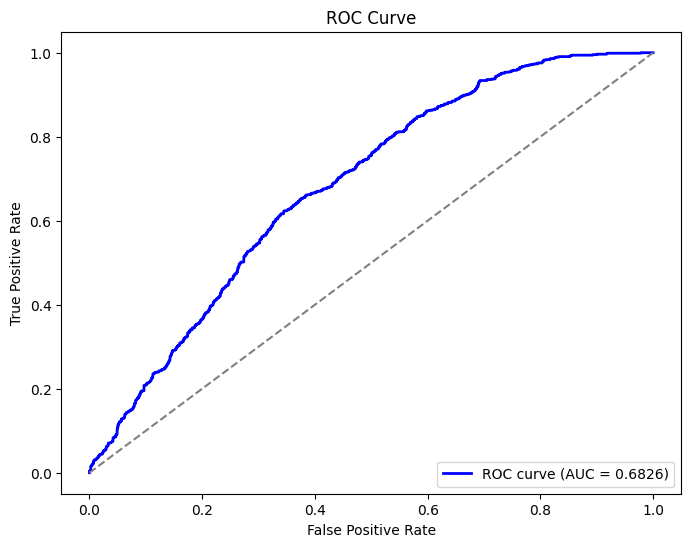

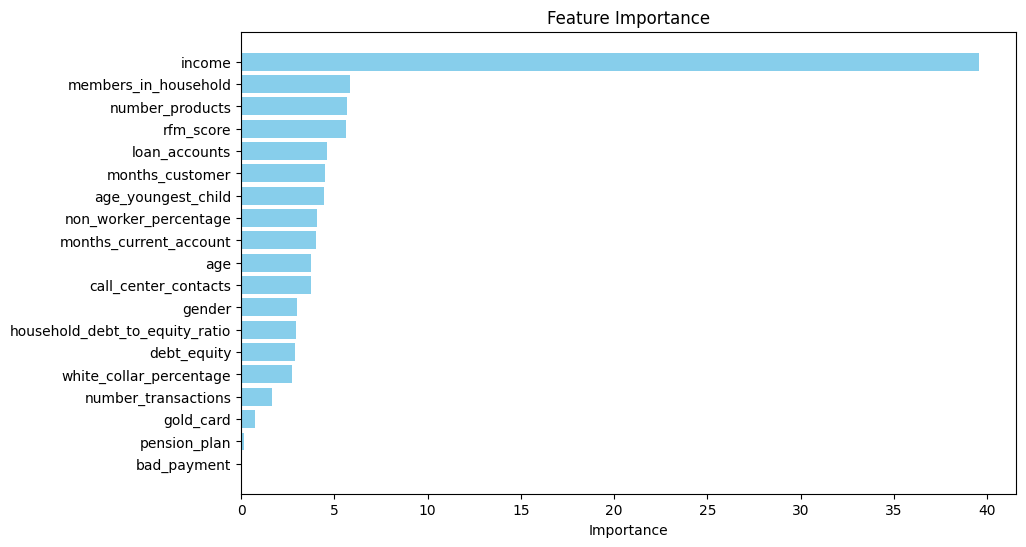


===== Кодировка категориальных признаков: ordinal ======

===== Обучение модели для таргета: Mortgage ======
0:	learn: 0.6390187	test: 0.6390296	best: 0.6390296 (0)	total: 14.9ms	remaining: 14.9s
500:	learn: 0.0840361	test: 0.2148499	best: 0.2011962 (85)	total: 6.24s	remaining: 6.21s
999:	learn: 0.0515156	test: 0.2412839	best: 0.2011962 (85)	total: 11.1s	remaining: 0us

bestTest = 0.2011961518
bestIteration = 85

Shrink model to first 86 iterations.

Метрики для модели Mortgage:
Accuracy: 0.8993
Precision: 0.6516
Recall: 0.6052
F1-score: 0.6275
Balanced Accuracy: 0.7762
AUC: 0.9432
LogLoss: 0.2012


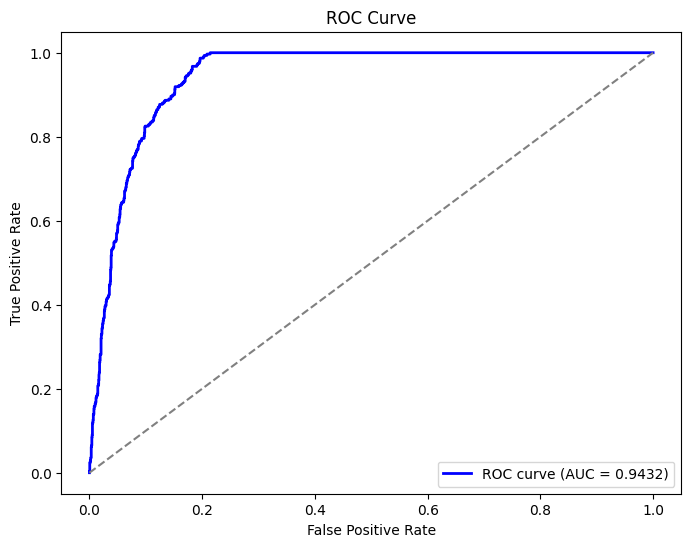

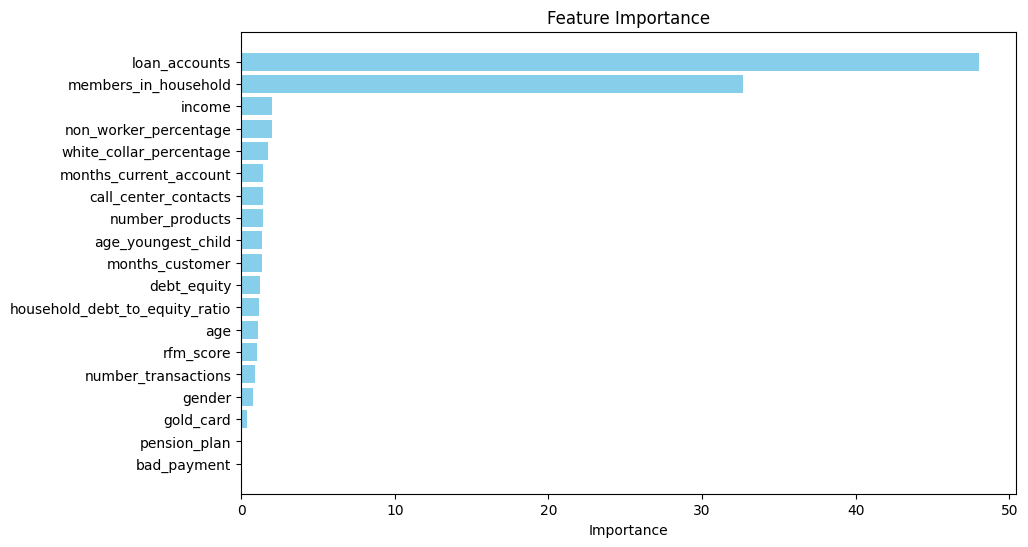


===== Обучение модели для таргета: Pension ======
0:	learn: 0.6706215	test: 0.6713880	best: 0.6713880 (0)	total: 9.31ms	remaining: 9.3s
500:	learn: 0.2463483	test: 0.4629508	best: 0.4406634 (91)	total: 6.17s	remaining: 6.14s
999:	learn: 0.1562687	test: 0.5075153	best: 0.4406634 (91)	total: 11.1s	remaining: 0us

bestTest = 0.4406633784
bestIteration = 91

Shrink model to first 92 iterations.

Метрики для модели Pension:
Accuracy: 0.7741
Precision: 0.4896
Recall: 0.0948
F1-score: 0.1588
Balanced Accuracy: 0.5330
AUC: 0.7661
LogLoss: 0.4407


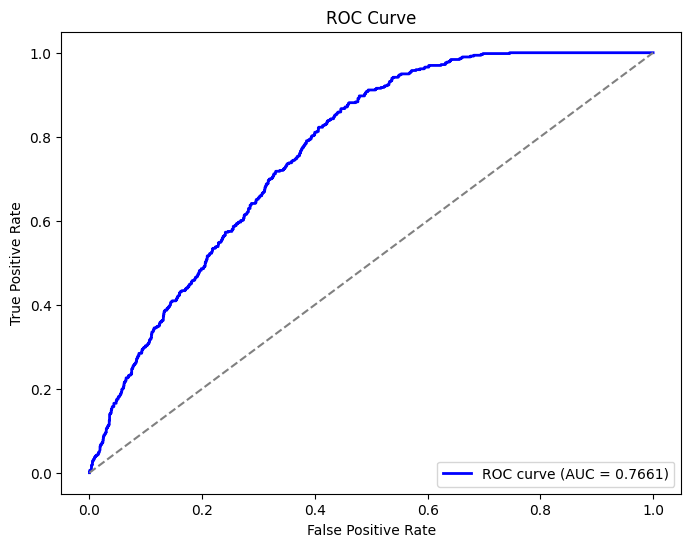

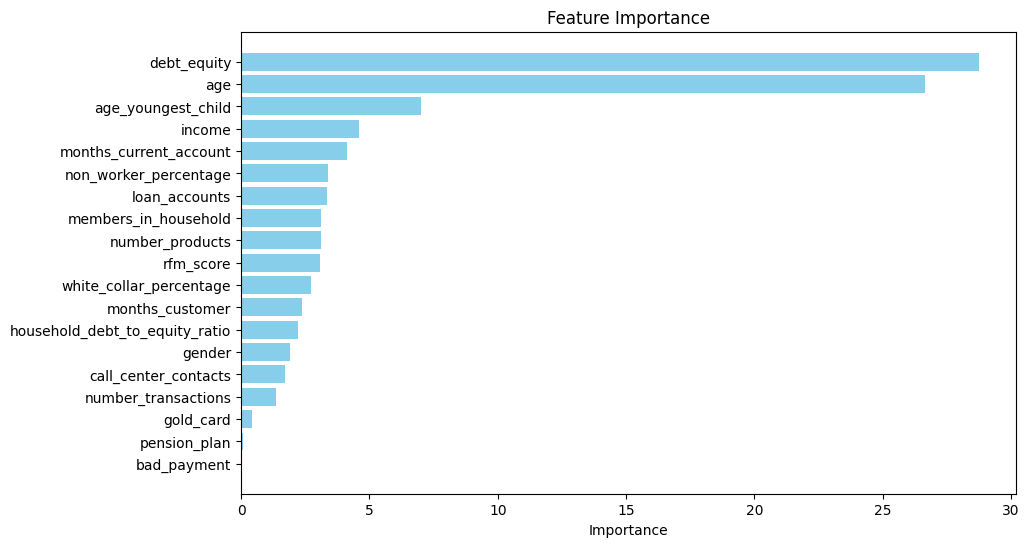


===== Обучение модели для таргета: Savings ======
0:	learn: 0.6858067	test: 0.6864175	best: 0.6864175 (0)	total: 9.47ms	remaining: 9.46s
500:	learn: 0.3986256	test: 0.6355016	best: 0.6085664 (91)	total: 7.49s	remaining: 7.46s
999:	learn: 0.2802485	test: 0.6780879	best: 0.6085664 (91)	total: 12.4s	remaining: 0us

bestTest = 0.6085663889
bestIteration = 91

Shrink model to first 92 iterations.

Метрики для модели Savings:
Accuracy: 0.6304
Precision: 0.5449
Recall: 0.3240
F1-score: 0.4064
Balanced Accuracy: 0.5753
AUC: 0.6826
LogLoss: 0.6086


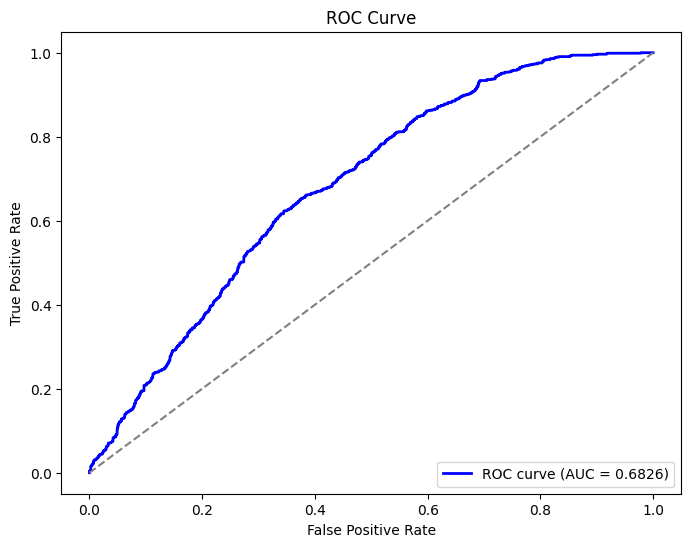

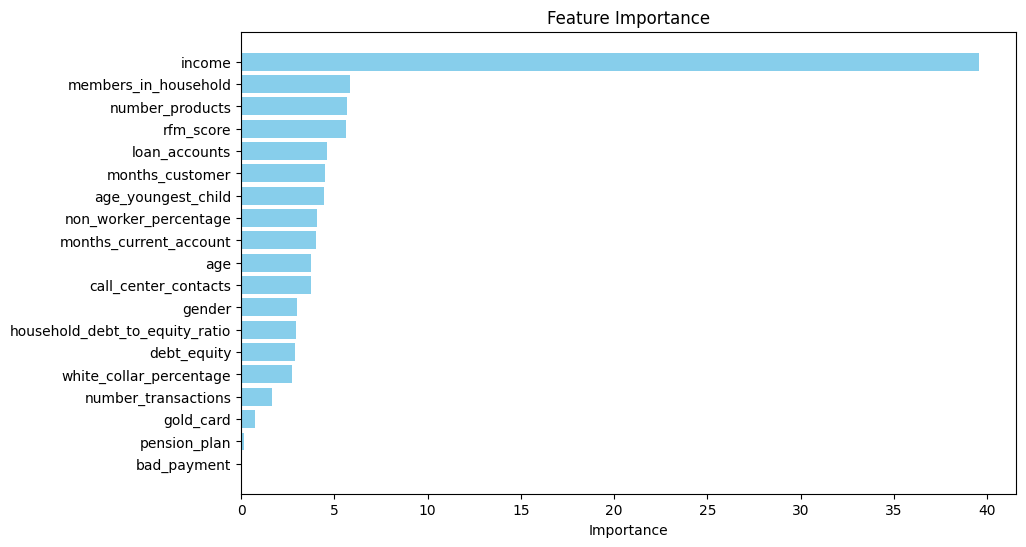

In [ ]:
for encoding in ['onehot', 'target', 'ordinal']:
    train_model(data, target_cols, cat_features, encoding_type=encoding)

Подберем лучшие гиперпараменты для модели

In [ ]:
param_distributions = {
    'iterations': [1000, 1500, 2000],
    'depth': [6, 8, 10],
    'learning_rate': np.linspace(0.005, 0.05, 5),
    'l2_leaf_reg': np.linspace(0.01, 10, 5)
}

def random_search_catboost(X, y, cat_features, n_iter=10):
    model = cb.CatBoostClassifier(
        loss_function='Logloss',
        cat_features=cat_features,
        task_type="GPU",
        bootstrap_type="Bayesian",
        grow_policy="Lossguide",
        random_strength=2,
        bagging_temperature=1,
        l2_leaf_reg=0.01,
        verbose=250

    )
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        scoring='roc_auc',
        cv=5,
        n_iter=n_iter,
        n_jobs=-1,
        random_state=42
    )
    random_search.fit(X, y)
    return random_search.best_estimator_, random_search.best_params_, random_search.best_score_

In [ ]:
best_models = {}
best_params = {}
best_scores = {}

for target in target_cols:
    print(f"\n===== Подбор гиперпараметров для таргета: {target} =====")
    X, y = prepare_data_for_target(data, target, cat_features)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    best_model, best_params[target], best_scores[target] = random_search_catboost(X_train, y_train, cat_features)
    best_models[target] = best_model

    print(f"Лучшие параметры для {target}: {best_params[target]}")
    print(f"Лучший ROC AUC: {best_scores[target]:.4f}")



===== Подбор гиперпараметров для таргета: Mortgage =====
0:	learn: 0.6865020	total: 29.3ms	remaining: 43.9s
250:	learn: 0.1952561	total: 3.28s	remaining: 16.3s
500:	learn: 0.1772667	total: 6.37s	remaining: 12.7s
750:	learn: 0.1667510	total: 11.8s	remaining: 11.7s
1000:	learn: 0.1580055	total: 15.1s	remaining: 7.51s
1250:	learn: 0.1503559	total: 18.2s	remaining: 3.63s
1499:	learn: 0.1438618	total: 23.7s	remaining: 0us
Лучшие параметры для Mortgage: {'learning_rate': 0.005, 'l2_leaf_reg': 10.0, 'iterations': 1500, 'depth': 8}
Лучший ROC AUC: 0.9452

===== Подбор гиперпараметров для таргета: Pension =====
0:	learn: 0.6880801	total: 14.9ms	remaining: 22.4s
250:	learn: 0.4187747	total: 5.63s	remaining: 28s
500:	learn: 0.3949041	total: 8.87s	remaining: 17.7s
750:	learn: 0.3789306	total: 12.1s	remaining: 12s
1000:	learn: 0.3649734	total: 17.3s	remaining: 8.64s
1250:	learn: 0.3516823	total: 20.4s	remaining: 4.07s
1499:	learn: 0.3396965	total: 23.5s	remaining: 0us
Лучшие параметры для Pension: